In [1]:
import itertools
import lifetimes
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from datetime import date
import plotly.figure_factory as ff
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from kneed import KneeLocator
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler


pio.renderers.default='notebook'
sns.set(rc={'figure.figsize':(11,6)})
sns.color_palette("Set2")

retail_data = pd.read_csv(r'C:\Users\Shashank Gupta\Documents\Courses\AML\Algorithmic Machine Learning\Project\online_retail_II.csv')

In [2]:
retail_data.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom

In [3]:
retail_data.shape

(1067371, 8)

In [4]:
retail_data.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [5]:
retail_data = retail_data.dropna(subset=['Customer ID'])
retail_data['Customer ID'] = retail_data['Customer ID'].astype(str)

In [6]:
retail_data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [7]:
order_status = []
for qty in retail_data['Quantity']:
    if qty < 0:
        order_status.append('Cancelled')
    else:
        order_status.append('Delivered')
        
retail_data['Order_Status'] = order_status

In [8]:
retail_data.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price Customer ID         Country Order_Status  
0  2009-12-01 07:45:00   6.95     13085.0  United Kingdom    Delivered  
1  2009-12-01 07:45:00   6.75     13085.0  United Kingdom    Delivered  
2  2009-12-01 07:45:00   6.75     13085.0  United Kingdom    Delivered  
3  2009-12-01 07:45:00   2.10     13085.0  United Kingdom    Delivered  
4  2009-12-01 07:45:00   1.25     13085.0  United Kingdom    Delivered

In [9]:
retail_data["Order_Status"].value_counts()

Delivered    805620
Cancelled     18744
Name: Order_Status, dtype: int64

In [10]:
retail_data['Total Amount'] = retail_data['Price'] * retail_data['Quantity']

In [11]:
# mask = retail_data['Quantity'] > 0
# retail_data = retail_data.loc[mask] 

In [12]:
cancelled_mask = retail_data["Invoice"].str.contains('C', na=False)
retail_data = retail_data[~cancelled_mask]

In [13]:
print('Total Number of Unique Customers in the table are: {}'.format(len(retail_data['Customer ID'].unique())))

Total Number of Unique Customers in the table are: 5881


In [14]:
customer_country= retail_data[['Customer ID', 'Country']].drop_duplicates()

In [15]:
top_countries = customer_country['Country'].value_counts().head(8)
top_countries = pd.DataFrame(top_countries)
top_countries = top_countries.reset_index()
top_countries.columns = ['Country', 'Country_Frequency']

In [16]:
top_countries

Country  Country_Frequency
0  United Kingdom               5353
1         Germany                107
2          France                 95
3           Spain                 41
4         Belgium                 29
5        Portugal                 24
6     Netherlands                 22
7     Switzerland                 22

In [17]:
fig = px.bar(top_countries, x="Country_Frequency", y="Country", title="Country vs Number of Customers", text_auto='.2s')
fig.show()

In [18]:
avg_spending = retail_data.groupby(['Country'])['Price'].agg(np.mean).sort_values(ascending=False)

In [19]:
avg_spending.head(8)

Country
Singapore    39.299410
Norway       14.195344
Malta        13.361773
Lebanon       5.387556
EIRE          5.315166
Cyprus        5.095645
Portugal      5.058557
Sweden        4.891835
Name: Price, dtype: float64

In [20]:
px.scatter(retail_data.iloc[:, [5, 7]].groupby(["Country"]).mean(),
            y = "Price", size = "Price", title = "Average Price by Country")

In [21]:
px.scatter(retail_data.iloc[:, [3, 7]].groupby(["Country"]).mean(),
           y = "Quantity", size = "Quantity", title = "Average Quantity Ordered by Country")

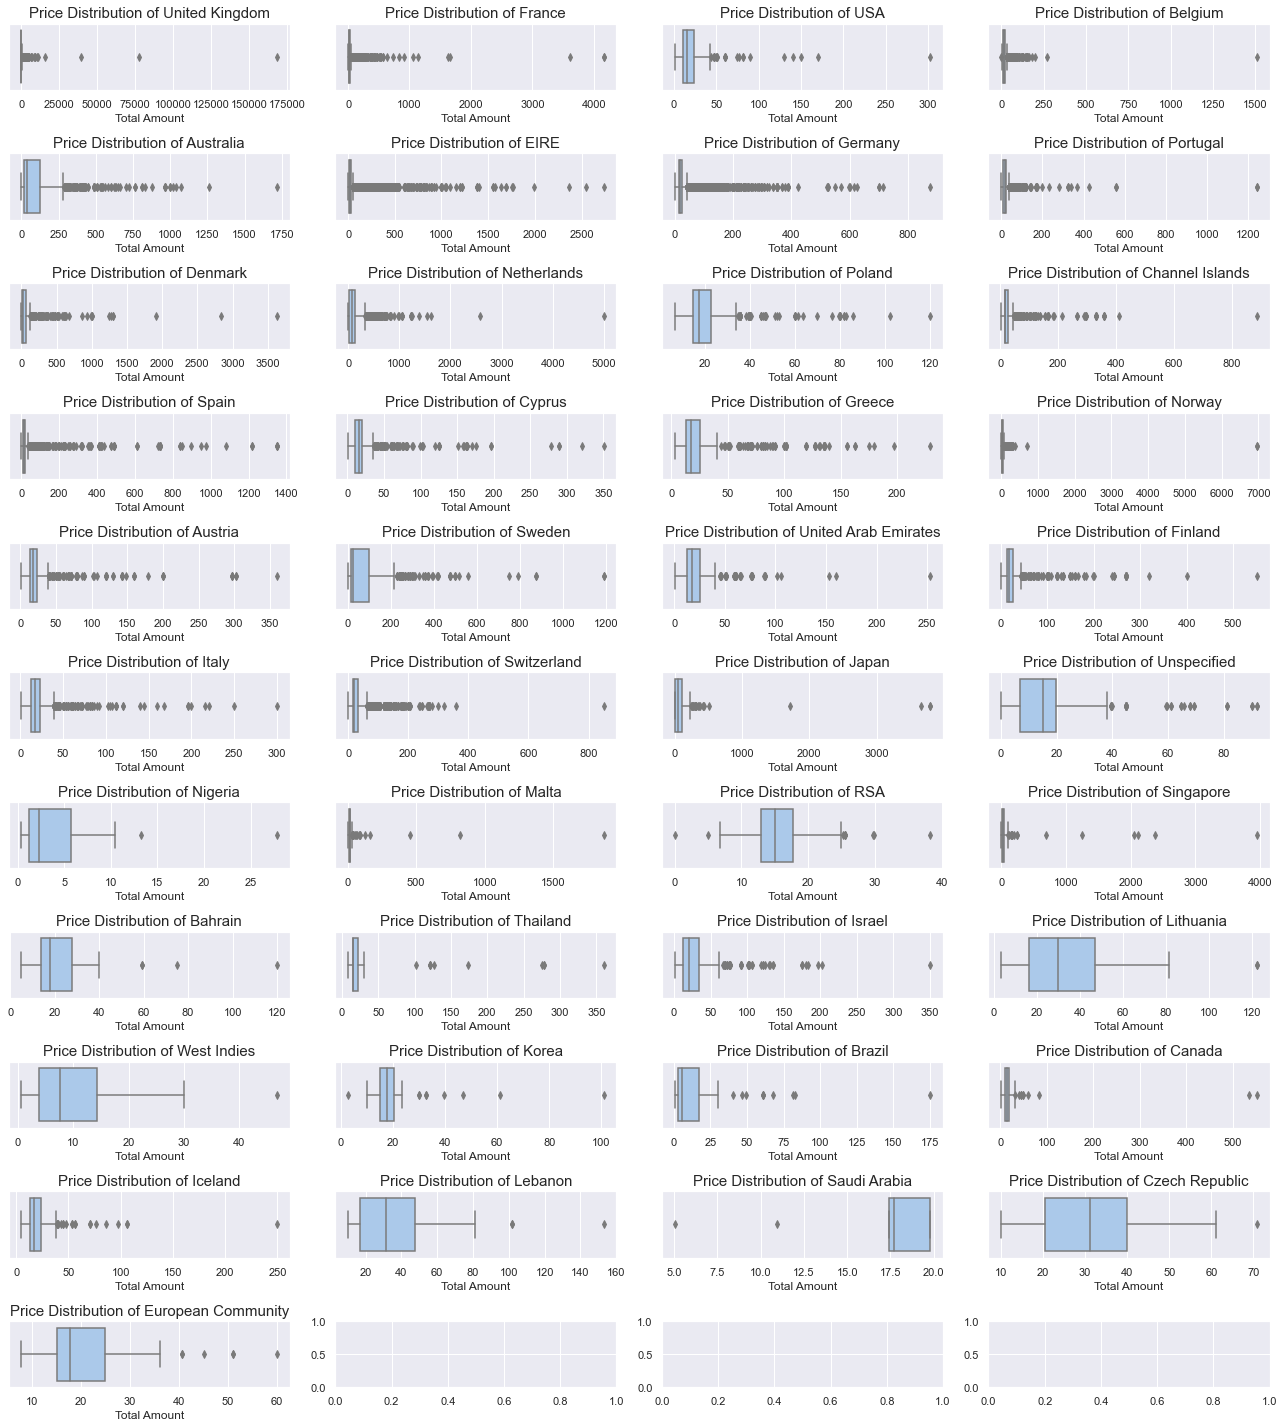

In [22]:
fig, axs = plt.subplots(11, 4, figsize=(18, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

for ax, con in zip(axs.ravel(), retail_data['Country'].unique()):
    unit_pricing_comparison = retail_data[retail_data['Country'] == con]
    sns.boxplot(x = unit_pricing_comparison['Total Amount'], ax=ax, palette = "pastel")
    ax.set_title('Price Distribution of {}'.format(str(con)), fontsize=15)
    plt.tight_layout()

# RFM Analysis

In [23]:
retail_data['InvoiceDate'] = pd.to_datetime(retail_data['InvoiceDate'])
PRESENT = retail_data["InvoiceDate"].max()

In [24]:
rfm = retail_data.groupby('Customer ID').agg({'InvoiceDate': lambda date: (PRESENT - date.max()).days,
                                              'Invoice': lambda num: num.nunique(),
                                              'Total Amount': lambda price: price.sum()})
rfm.columns=['recency','frequency','monetary']
rfm.head()

recency  frequency  monetary
Customer ID                              
12346.0          325         12  77556.46
12347.0            1          8   5633.32
12348.0           74          5   2019.40
12349.0           18          4   4428.69
12350.0          309          1    334.40

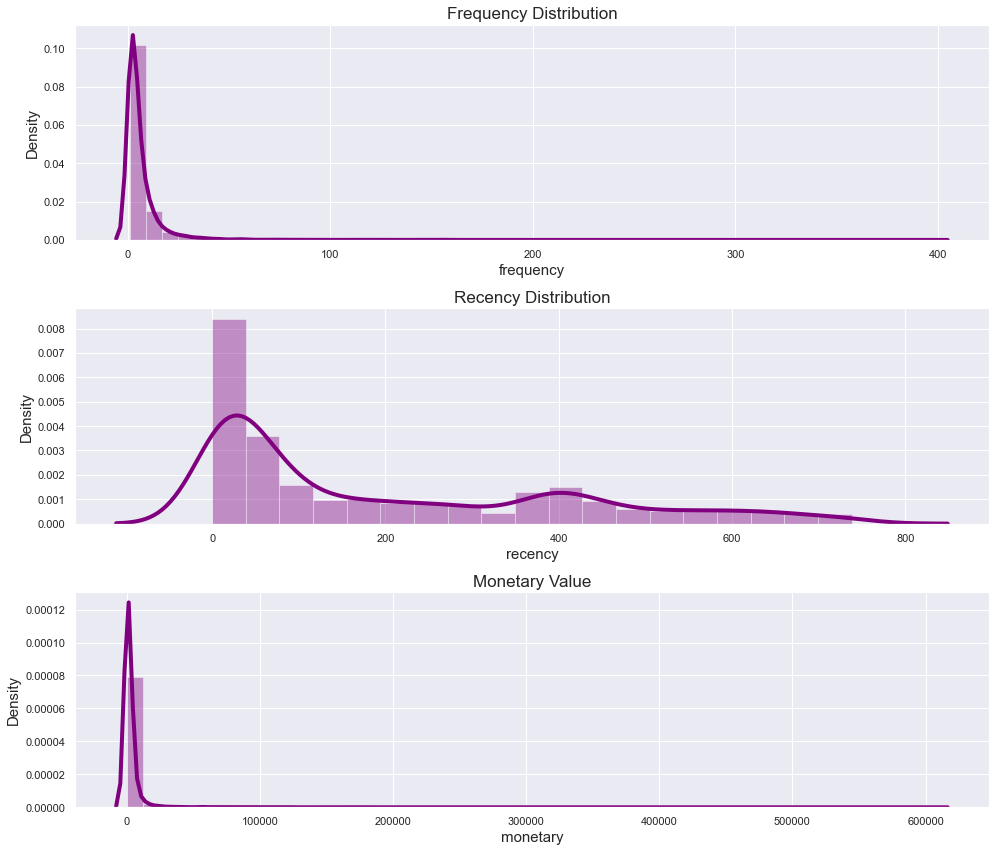

In [25]:
fig, axs = plt.subplots(3,1, figsize=(14, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

category = ["frequency", "recency", "monetary"]
title = ["Frequency Distribution", "Recency Distribution", "Monetary Value"]
for ax, cat, title in itertools.zip_longest(axs.ravel(), category, title):
    sns.distplot(x = rfm[cat], ax=ax, kde_kws=dict(linewidth=4), color='purple')
    ax.set_title(title, fontsize=17)
    ax.set_xlabel(cat, fontsize=15)
    ax.set_ylabel('Density', fontsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    plt.tight_layout()

# Automated RFM Feature Extraction

In [26]:
rfm_summary = lifetimes.utils.summary_data_from_transaction_data(retail_data, "Customer ID", "InvoiceDate", "Total Amount")

In [27]:
rfm_summary.head()

frequency  recency      T  monetary_value
Customer ID                                           
12346.0            7.0    400.0  725.0    11066.637143
12347.0            7.0    402.0  404.0      717.398571
12348.0            4.0    363.0  438.0      449.310000
12349.0            3.0    571.0  589.0     1120.056667
12350.0            0.0      0.0  310.0        0.000000

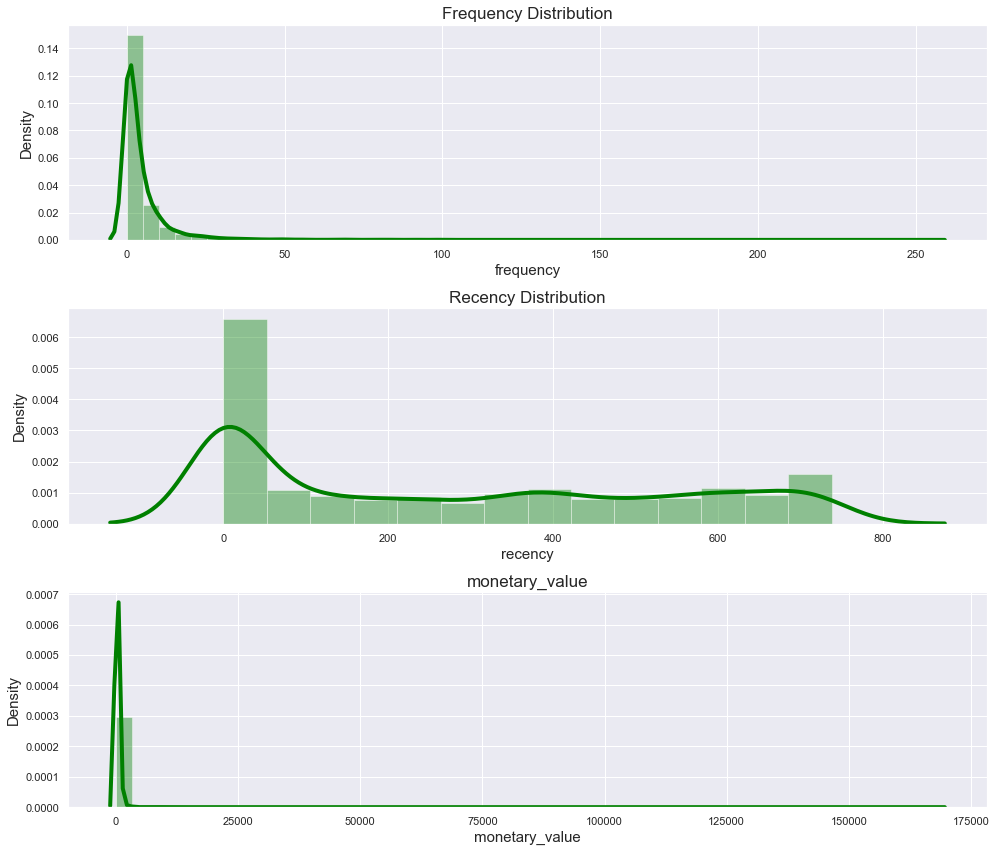

In [28]:
fig, axs = plt.subplots(3, 1, figsize=(14, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

category = ["frequency", "recency", "monetary_value"]
title = ["Frequency Distribution", "Recency Distribution", "monetary_value"]
for ax, cat, title in itertools.zip_longest(axs.ravel(), category, title):
    sns.distplot(x = rfm_summary[cat], ax=ax, kde_kws=dict(linewidth=4), color='green')
    ax.set_title(title, fontsize=17)
    ax.set_xlabel(cat, fontsize=15)
    ax.set_ylabel('Density', fontsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=14)
    plt.tight_layout()

In [29]:
rfm_summary = rfm_summary[rfm_summary["monetary_value"]<100000]
fig = px.scatter(rfm_summary, x="frequency", y="monetary_value", color='recency', size='T')
fig.update_layout(title_text='Customer Frequency vs Monetary Value Comparison', xaxis_title="Customer Frequency", yaxis_title="Monetary Value")
fig.show()

In [30]:
q = [0, 0.28, 0.5, 0.75, 1]
rfm["recency_score"] = pd.qcut(rfm["recency"], q=q, labels=[4, 3, 2, 1]).astype(int)
rfm["frequency_score"] = pd.qcut(rfm["frequency"], q=q, labels=[1, 2, 3, 4]).astype(int)
rfm["monetary_score"] = pd.qcut(rfm["monetary"], q=q, labels=[1, 2, 3, 4]).astype(int)

segt_map = {
    r"[1-2][1-2]": "Hibernating",
    r"[1-2][2-3]": "At-Risk",
    r"[1-2]4": "Cannot lose them",
    r"2[1-2]": "About To Sleep",
    r"22": "Need Attention",
    r"[2-3][3-4]": "Loyal Customers",
    r"31": "Promising",
    r"41": "New Customers",
    r"[3-4][1-2]": "Potential Loyalists",
    r"4[3-4]": "Champions",
}

rfm["Segment"] = (rfm["recency_score"].map(str) + rfm["frequency_score"].map(str)).replace(segt_map, regex=True)
rfm["Overall Score"] = rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str) + rfm["monetary_score"].astype(str)
rfm["Overall Score"] = rfm["Overall Score"].astype(int)
rfm_table = rfm
rfm_table.head()

recency  frequency  monetary  recency_score  frequency_score  \
Customer ID                                                                 
12346.0          325         12  77556.46              2                4   
12347.0            1          8   5633.32              4                4   
12348.0           74          5   2019.40              3                3   
12349.0           18          4   4428.69              4                3   
12350.0          309          1    334.40              2                1   

             monetary_score           Segment  Overall Score  
Customer ID                                                   
12346.0                   4  Cannot lose them            244  
12347.0                   4         Champions            444  
12348.0                   3   Loyal Customers            333  
12349.0                   4         Champions            434  
12350.0                   1       Hibernating            211

In [31]:
rfm_table['Segment'].value_counts()

Hibernating            2185
Champions              1183
Loyal Customers         722
At-Risk                 553
Promising               421
Potential Loyalists     327
New Customers           301
Cannot lose them        189
Name: Segment, dtype: int64

In [32]:
rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot lose them": [4, 5, 0, 0.4],
                   "At-Risk": [2, 4, 0, 0.4],
                   "Hibernating": [0, 2, 0, 0.4],
                   "About To Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}


plt.rcParams["axes.facecolor"] = "white"
palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
           "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]

fig = go.Figure()

df_shp = pd.DataFrame(rfm_coordinates).T.rename(
    columns={0: "y0", 1: "y1", 2: "x0", 3: "x1"})

df_shp["fillcolor"] = palette
df_shp.loc[:, ["x0", "x1"]] = df_shp.loc[:, ["x0", "x1"]] * 5


for segment, r in df_shp.iterrows():
    fig.add_shape(**r.to_dict(), opacity=0.6)

fig.update_layout(
    xaxis=dict(range=[0, 5], dtick=1, showgrid=False),
    yaxis=dict(range=[0, 5], showgrid=False),
    margin={"l": 0, "r": 0, "b": 0, "t": 0},
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
)

df_txt = (
    rfm_table.groupby("Segment")
    .agg(avg_monetary=("monetary", "mean"), number=("monetary", "size"))
    .join(df_shp, how="outer")
    .fillna(0))

fig.add_trace(
    go.Scatter(
        x=df_txt.loc[:, ["x0", "x1"]].mean(axis=1),
        y=df_txt.loc[:, ["y0", "y1"]].mean(axis=1),
        text=df_txt.index,
        customdata=df_txt.loc[:, ["avg_monetary", "number"]].astype(int).values,
        mode="text",
        texttemplate="<b>%{text}</b><br>Total Users:%{customdata[1]}<br>Average Monetary:%{customdata[0]}",
    )
)

In [33]:
rfm['frequency'] = rfm['frequency'][rfm["frequency"] < 200]
rfm['monetary'] = rfm['monetary'][rfm['monetary'] < 200000]
fig = px.scatter(rfm, x="recency", y="frequency", color='Segment', opacity=0.7)
fig.update_layout(title_text='Customer Recency vs Customer Frequency Comparison',
                  xaxis_title="Customer Recency", yaxis_title="Customer Frequnecy")
fig.show()

# Customer Segmentation using CLTV

In [34]:
rfm_summary["average_monetary"] = rfm_summary["monetary_value"] / rfm_summary["frequency"] # Finding Average Monetary Value
cltv_df = rfm_summary[(rfm_summary['frequency'] > 1)] # Finding customers making purchase more than once
cltv_df["recency"] = cltv_df["recency"] / 7 # Converting recency as a weekly variable
cltv_df["T"] = cltv_df["T"] / 7 # Converting T as a weekly variable
print(cltv_df.shape)
cltv_df.head()

(3185, 5)


frequency    recency           T  monetary_value  \
Customer ID                                                     
12346.0            7.0  57.142857  103.571429    11066.637143   
12347.0            7.0  57.428571   57.714286      717.398571   
12348.0            4.0  51.857143   62.571429      449.310000   
12349.0            3.0  81.571429   84.142857     1120.056667   
12352.0            8.0  50.857143   56.000000      338.261250   

             average_monetary  
Customer ID                    
12346.0           1580.948163  
12347.0            102.485510  
12348.0            112.327500  
12349.0            373.352222  
12352.0             42.282656

In [35]:
bgf = BetaGeoFitter(penalizer_coef=0.0001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

# Finding expected purchases after 1 week
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])
# Finding expected purchases after 1 month (4 week)
cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])
cltv_df.head()

frequency    recency           T  monetary_value  \
Customer ID                                                     
12346.0            7.0  57.142857  103.571429    11066.637143   
12347.0            7.0  57.428571   57.714286      717.398571   
12348.0            4.0  51.857143   62.571429      449.310000   
12349.0            3.0  81.571429   84.142857     1120.056667   
12352.0            8.0  50.857143   56.000000      338.261250   

             average_monetary  expected_purc_1_week  expected_purc_1_month  
Customer ID                                                                 
12346.0           1580.948163              0.038564               0.154053  
12347.0            102.485510              0.118545               0.473175  
12348.0            112.327500              0.071369               0.284955  
12349.0            373.352222              0.047018               0.187814  
12352.0             42.282656              0.133844               0.534195

# Estimating Customer using K-Means & CLTV estimates

In [36]:
# Gamma Gamma
# It'll show us expected average profit
ggf = GammaGammaFitter(penalizer_coef=0.0001)
ggf.fit(cltv_df['frequency'], cltv_df['average_monetary'])

# Prediction
cltv_df['CLTV'] = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['average_monetary'],
                                   time=6,              # 6 months
                                   freq="W",            # 'W':Weekly
                                   discount_rate=0.01)
cltv_df.head()
cltv_df = cltv_df.reset_index()
cltv_df.sort_values(by="CLTV", ascending=False).head(10)

Customer ID  frequency     recency           T  monetary_value  \
929      14096.0       16.0   13.857143   14.428571     4071.434375   
2760     17450.0       30.0   61.428571   62.571429     6924.523000   
3101     18102.0       66.0  105.428571  105.428571     9189.930455   
37       12415.0       22.0   71.857143   75.285714     6460.528636   
306      12950.0        2.0    3.142857    3.428571      765.700000   
210      12753.0        5.0   48.571429   51.714286     3567.760000   
2784     17509.0        2.0    0.857143    9.000000      898.140000   
0        12346.0        7.0   57.142857  103.571429    11066.637143   
927      14088.0       13.0   58.714286   60.142857     3949.358462   
57       12454.0        4.0   52.142857   60.142857     2986.565000   

      average_monetary  expected_purc_1_week  expected_purc_1_month  \
929         254.464648              0.589350               2.344260   
2760        230.817433              0.404731               1.615174   
3101        139.241371              0.559583               2.234830   
37          293.660393              0.258765               1.033038   
306         382.850000              0.195820               0.778209   
210         713.552000              0.098970               0.395013   
2784        449.070000              0.140631               0.559672   
0          1580.948163              0.038564               0.154053   
927         303.796805              0.193517               0.772347   
57          746.641250              0.074172               0.296128   

             CLTV  
929   3632.591030  
2760  2311.353471  
3101  1938.774501  
37    1884.581105  
306   1799.905970  
210   1743.413871  
2784  1526.981698  
0     1515.105002  
927   1455.013142  
57    1369.025110

In [37]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv_df[["CLTV"]])
cltv_df["scaled_clv"] = scaler.transform(cltv_df[["CLTV"]])
cltv_df.sort_values(by="scaled_clv", ascending=False).head(10)

Customer ID  frequency     recency           T  monetary_value  \
929      14096.0       16.0   13.857143   14.428571     4071.434375   
2760     17450.0       30.0   61.428571   62.571429     6924.523000   
3101     18102.0       66.0  105.428571  105.428571     9189.930455   
37       12415.0       22.0   71.857143   75.285714     6460.528636   
306      12950.0        2.0    3.142857    3.428571      765.700000   
210      12753.0        5.0   48.571429   51.714286     3567.760000   
2784     17509.0        2.0    0.857143    9.000000      898.140000   
0        12346.0        7.0   57.142857  103.571429    11066.637143   
927      14088.0       13.0   58.714286   60.142857     3949.358462   
57       12454.0        4.0   52.142857   60.142857     2986.565000   

      average_monetary  expected_purc_1_week  expected_purc_1_month  \
929         254.464648              0.589350               2.344260   
2760        230.817433              0.404731               1.615174   
3101        139.241371              0.559583               2.234830   
37          293.660393              0.258765               1.033038   
306         382.850000              0.195820               0.778209   
210         713.552000              0.098970               0.395013   
2784        449.070000              0.140631               0.559672   
0          1580.948163              0.038564               0.154053   
927         303.796805              0.193517               0.772347   
57          746.641250              0.074172               0.296128   

             CLTV  scaled_clv  
929   3632.591030    1.000000  
2760  2311.353471    0.636282  
3101  1938.774501    0.533717  
37    1884.581105    0.518798  
306   1799.905970    0.495488  
210   1743.413871    0.479937  
2784  1526.981698    0.420356  
0     1515.105002    0.417087  
927   1455.013142    0.400544  
57    1369.025110    0.376873

In [38]:
features = cltv_df[['frequency', 'recency', 'T', 'monetary_value', 'CLTV']]

In [39]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# K-Means For Clustering

In [40]:
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

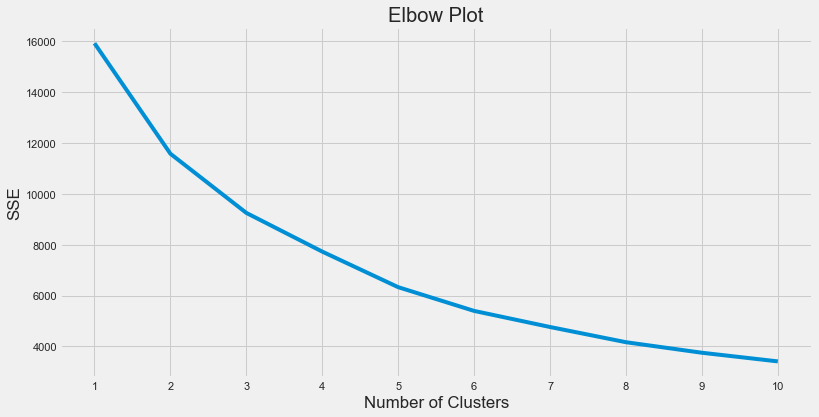

In [41]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), sse)
plt.title('Elbow Plot')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [42]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

In [43]:
kl.elbow

5

In [44]:
optimal_kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
optimal_kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=5, random_state=42)

In [45]:
predicted_labels = optimal_kmeans.labels_

In [46]:
cltv_df['Predicted Labels'] = predicted_labels

# Visualizing Customer Clusters

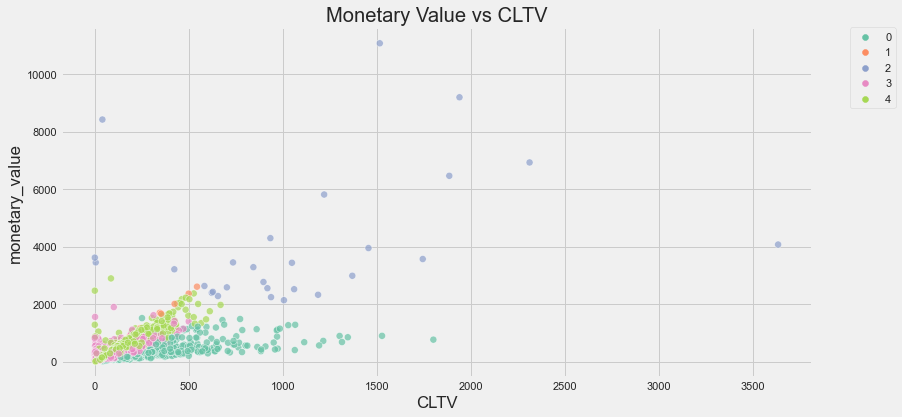

In [47]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12, 6))

scat = sns.scatterplot(
       "CLTV",
       "monetary_value",
       s=50,
       data=cltv_df,
       hue="Predicted Labels",
       palette="Set2",
       alpha=0.7)
scat.set_title("Monetary Value vs CLTV")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

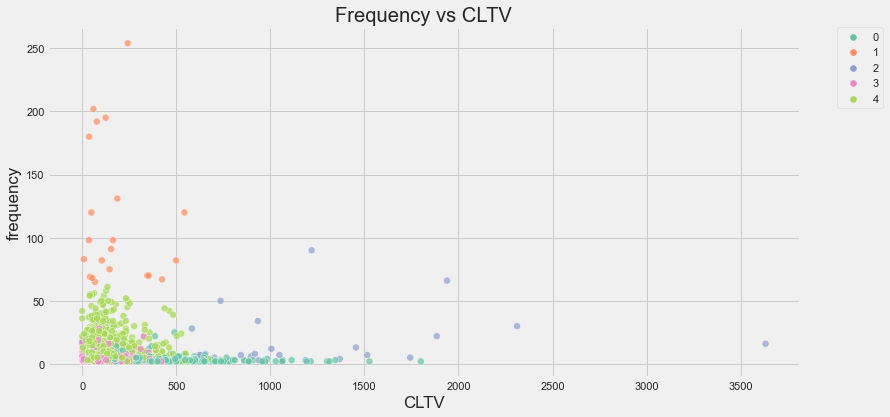

In [48]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12, 6))

scat = sns.scatterplot(
       "CLTV",
       "frequency",
       s=50,
       data=cltv_df,
       hue="Predicted Labels",
       palette="Set2",
       alpha=0.7)

scat.set_title("Frequency vs CLTV")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

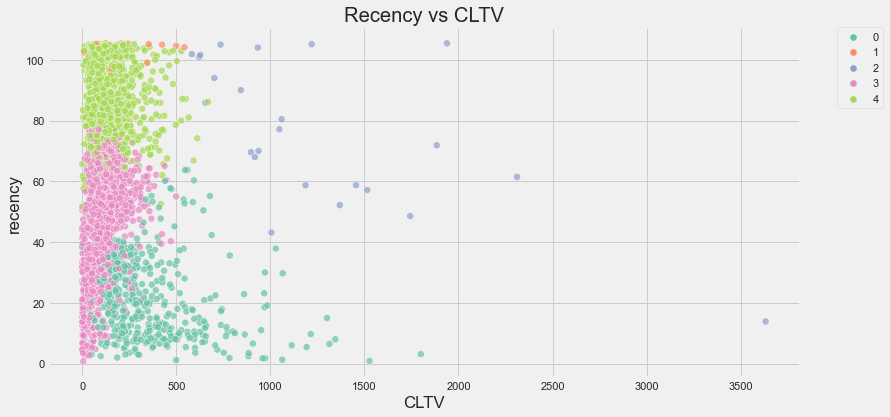

In [49]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12, 6))

scat = sns.scatterplot(
       "CLTV",
       "recency",
       s=50,
       data=cltv_df,
       hue="Predicted Labels",
       palette="Set2",
       alpha = 0.7)

scat.set_title("Recency vs CLTV")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

In [50]:
rfm_clusters = cltv_df[["recency", "frequency", "monetary_value", "Predicted Labels"]]

In [51]:
rfm_clusters.groupby(['Predicted Labels']).agg({'recency': 'mean',
                                                'frequency': 'mean',
                                                'monetary_value': ['mean', 'count'],}).round(3)

recency frequency monetary_value      
                     mean      mean           mean count
Predicted Labels                                        
0                  21.583     3.851        374.739   430
1                 103.830   114.857        839.061    21
2                  67.872    16.750       4073.334    28
3                  47.249     4.273        307.822  1225
4                  89.675    11.111        452.957  1481

In [52]:
rfm_clusters = rfm_clusters[["recency", "frequency", "monetary_value"]]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(rfm_clusters)
rfm_clusters = pd.DataFrame(x_scaled)

In [53]:
rfm_clusters.columns = ["recency", "frequency", "monetary_value"]
rfm_clusters["Predicted Labels"] = cltv_df["Predicted Labels"]

In [54]:
cluster_avg = rfm_clusters.groupby(['Predicted Labels']).mean()
population_avg = rfm_clusters.mean()
relative_imp = cluster_avg / population_avg - 1

In [55]:
relative_imp = relative_imp[["recency", "frequency", "monetary_value"]].round(2)

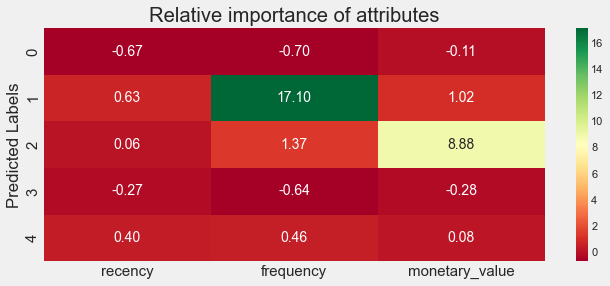

In [56]:
plt.figure(figsize=(10, 4))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()